# A4: Univariate Probability

---

*Purpose*: Probability is a useful way to represent uncertainty. However, working with probability is challenging. Over the next few notebooks we'll learn the basics of modeling with probability, use Monte Carlo to work with random models, and incorporate information about random quantities in optimization.

*Learning Objectives*: By working through this assignment, you will 
- understand fundamental concepts about random variables: variability, mean, standard deviation, quantiles, probability
- connect these fundamental concepts to engineering concerns, such as failure rates and robustness
- use Monte Carlo to propagate uncertainty
- conduct a literature search to define a *principled* random variable model

*Reading*:
- Kochenderfer and Wheeler, Ch 17.3
- (Optional) Owen ["Monte Carlo theory, methods and examples"](https://statweb.stanford.edu/~owen/mc/), an excellent ground-up, detailed theoretical treatment of Monte Carlo



### Assignment Checklist

1. [?] Make sure you have answered all questions. These are marked with a **qX.Y**
1. [?] Make sure you complete the Project Task at the end of the assignment. These will scaffold your project progress during the semester.
1. [?] Make sure your notebook passes all `assert()` statements. You will not get full credit for the assignment if a single `assert()` fails.
1. [?] Make sure your notebook runs: `Kernel > Restart kernel and run all cells...`
1. [?] Upload your notebook to Canvas.


### Grading Rubric

Every assignment is worth 10 points; it is not possible to receive less than 0 points. For each question (qX.Y) on a given assignment, the following grading rubric will be applied. For every NI that you receive, one point will be subtracted from your assignment total. For reference, to receive an A- in this class, you will need an average of 9 points across your 5 best assignments, meaning you need to have at most one mistake on your final submission for 5 assignments. To achieve this, you should take advantage of both the Draft and Final submission deadlines.

| Category     | Needs Improvement (NI)                     | Satisfactory (S)                       |
|--------------|--------------------------------------------|----------------------------------------|
| Effort       | qX.Y left unattempted                      | qX.Y attempted                         |
| Assertions   | Code does not pass an `assert()`           | All `assert()`s pass, or no assertions |
| Observations | Any point under *observe* left unattempted | All *observe*s attempted and correct,  |
|              | Provided an incorrect observation          | or no *observe*s for that q            |


## S1: Probability as a Measure of Uncertainty

---

Probability is ultimately a *quantitative measure of uncertainty*. A probabilistic approach models randomness in variables as so-called *random variables*. In this section, you'll get some practice using probability to model uncertain quantities.


In [1]:
import grama as gr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Define the data pronoun as DF
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### An Example Probability Model: Strength of a brittle material

The (tensile) strength of brittle materials is often modeled using a *random variable* (e.g. Afferrante et al. 2006). Random variables are used because real materials *do not* come off an assembly line and behave identically; instead, they tend to exhibit *unavoidable variation in performance*. In fact, aircraft designers are *legally required* to treat material properties rigorously using both probability and statistics (CFR 25.613).

As an illustrative example, let's look at a random variable model for the tensile strength of ceramic alumina.


In [2]:
## NOTE: No need to edit, this sets up a probability model for the strength of a ceramic
# Set up the model
md_strength = (
    gr.Model()
    >> gr.cp_marginals(
        sigma_t=dict(
            dist="weibull_min",
            loc=0,     # Zero offset (-)
            scale=200, # Alumina, 96% pure (MPa), Ref: STC
            c=2.0,     # High-scatter Weibull modulus (-), Ref: Afferrante et al. (2006)
        )
    )
    >> gr.cp_copula_independence()
)
md_strength.printpretty()

model: None

  inputs:
    var_det:
    var_rand:
      sigma_t: (+0) weibull_min, {'loc': 0, 'scale': 200, 'c': 2.0}
    copula:
        Independence copula
  functions:


This Grama model has no function; it only defines a single *random variable* (`var_rand`) `sigma_t`. A random variable is a quantity that does not take a single definitive value, but instead can take a range of values with particular frequency. This model defines the material strength `sigma_t` as a random variable to represent the reality that components manufactured with this material will tend to be variable in strength. I defined a distribution with a particular shape `"weibull_min"` called a Weibull distribution; this is often used to model the strength of brittle materials such as ceramics. I also set parameter values `loc, scale, c` based on published resources. This is a **principled** way to build a random variable model. Principled random variable models should be based on literature search or real data.

Using the verb `gr.eval_monte_carlo()` we can generate *realizations* from the random variable. Each realization of this model represents a single component manufactured of ceramic alumina, which has its own unique value of strength $\sigma_{t,i}$. The process of generating a realization is called *drawing* a realization.


In [3]:
## NOTE: No need to edit, this draws realizations from the model
df_samples = (
    md_strength
    >> gr.ev_monte_carlo(n=1e5, df_det="nom", skip=True, seed=101)
    >> gr.tf_mutate(id=DF.index)
)
df_samples.head()


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


,sigma_t,id
0,170.469273,0
1,183.904737,1
2,33.992635,2
3,86.755883,3
4,215.040678,4


If we plot the first hundred realizations of strength, we will indeed see that the values tend to be different. Let's further assume that the individual components will be subject to an applied stress of $50$ MPa; then parts with $\sigma_{t,i} \leq 50$ MPa will break and fail. The following plot shows the first hundred realizations from `df_samples` and highlights those parts that would fail.


Text(0.5, 1.0, 'First hundred samples')

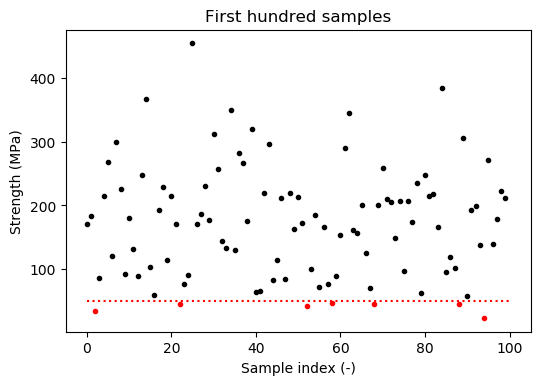

In [4]:
## NOTE: No need to edit; run and inspect
plt.figure()
plt.plot([0, 100], [50, 50], 'r:')
plt.plot(
    df_samples[(df_samples.id < 100) & (df_samples.sigma_t > 50)].id,
    df_samples[(df_samples.id < 100) & (df_samples.sigma_t > 50)].sigma_t,
    "k."
)
plt.plot(
    df_samples[(df_samples.id < 100) & (df_samples.sigma_t <= 50)].id,
    df_samples[(df_samples.id < 100) & (df_samples.sigma_t <= 50)].sigma_t,
    "r."
)
plt.xlabel("Sample index (-)")
plt.ylabel("Strength (MPa)")
plt.title("First hundred samples")


This scatterplot illustrates that the strength of the ceramic does in fact tend to vary, but otherwise this visual is not very informative. Instead, we can use a [histogram](https://en.wikipedia.org/wiki/Histogram) to assess the *shape* of the distribution of strength values.


### __q1.1__ Interpret a histogram

Interpret the histogram of realizations of `sigma_t` and answer the questions below.


Text(0, 0.5, 'Count (-)')

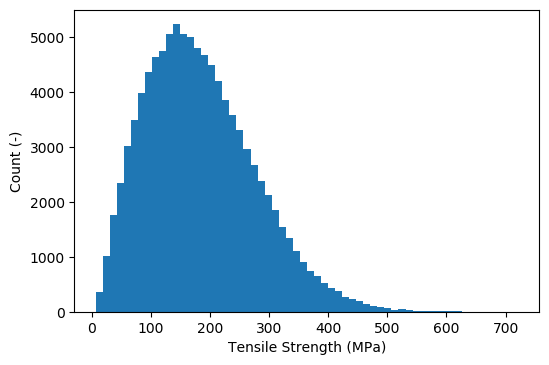

In [5]:
###
# TASK: Interpret the following histogram
###

## NOTE: No need to edit; run and interpret
plt.figure()
n, bins, patches = plt.hist(
    df_samples.sigma_t,
    bins=60,
    align="right",
)
plt.xlabel("Tensile Strength (MPa)")
plt.ylabel("Count (-)")


*Observe*:

- The strength of a material cannot be negative. Does the random variable model respect this physical principle? (yes or no)
  - yes
- *Roughly*, what value of strength tends to occur *most frequently*?
  - 150 MPa
- Imagine that you were designing a safety-critical part using this material, and failure would result in the death of a human. You will not apply any additional safety factors or knockdowns in your design process, beyond how you treat the material strength. Would you feel comfortable assuming your highest-frequency value above, for the purposes of designing this component? Why or why not?
  - I would definitely not feel comfortable assuming 150Mpa is the strength of the component. There are still a very significant group of samples that have less strength leading to a high probability of death.


### What is Probability?

Here is a reasonably jargon-free statement about what probability is:

> Probability is a quantitative statement about the *relative frequency* of **chosen events** associated with a particular **random variable**.

Note that probability is a statement about *relative frequencies*, and it requires two ingredients:

1. We must chose an **event** $A$ to study
2. We must choose a **random variable** $X$ to study

We define events as *sets* of values, often by stating some sort of inequality. We define random variables by carrying out random variable modeling.

With the ceramic failure problem, our event is failure of the component with the set $A = \{\sigma_t \,|\, \sigma_t \leq \sigma\}$. Our random variable is the variable material strength $X = \sigma_t$.

Once we settle on our event $A$ and with a *continuous* random variable $X$, we can formally define the probability of event $A$ occurring as

$$\mathbb{P}[X \in A] = \int_{-\infty}^{+\infty} 1(x \in A) f_X(x) dx = \mathbb{E}[1(X \in A)]$$

where $f_X(x)$ is the *probability density function* (PDF) of the random variable $X$, and $1(x \in A)$ is the *indicator function*; a function that takes the value $1$ when $x \in A$ and $0$ when $x \not\in A$.

The PDF $f_X(x)$ is a quantitative description of the *relative frequency* with which different values of $X$ occur. The interpretation is very similar to a histogram; in fact, a histogram is nothing more than a discrete approximation to a PDF.


Note that the definition of probability implies that *probability is the area under the PDF*. The following visual illustrates this fact with the ceramic strength histogram:


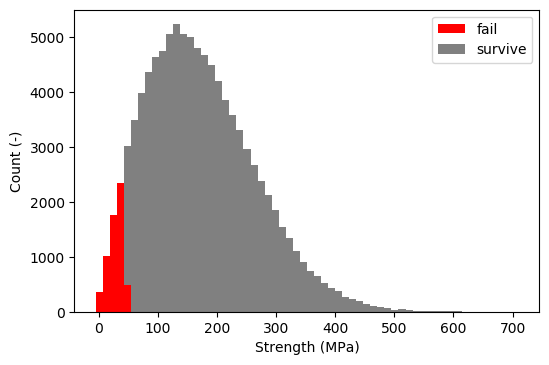

In [6]:
## NOTE: No need to edit, run and inspect
plt.figure()
plt.hist(
    [
        df_samples[df_samples.sigma_t < 50].sigma_t,
        df_samples[df_samples.sigma_t >= 50].sigma_t,
    ],
    color=["red", "grey"],
    label=["fail", "survive"],
    bins=60,
    align="left",
    histtype="barstacked",
)
plt.xlabel("Strength (MPa)")
plt.ylabel("Count (-)")
plt.legend(loc=0)

The red area corresponds to those cases where the ceramic fails to survive its loading conditions and breaks, possibly leading to failure of a system.

Remember that the histogram is a discrete approximation of the PDF $f_X(x)$. There are many complicated analytic formulae for PDFs, but within Grama you can access and evaluate the PDF of a random variable using its name `"var"` and the syntax:

> `md_strength.density.marginals["var"].l(x)`

The following code illustrates the PDF of the ceramic strength.


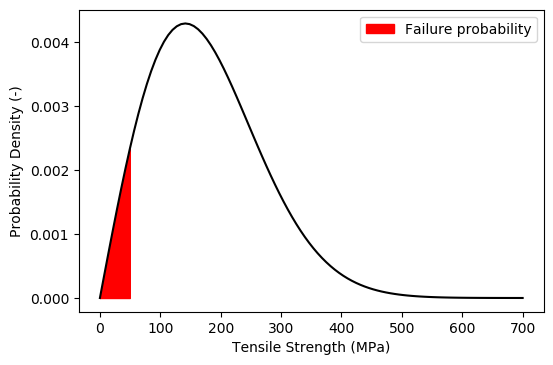

In [7]:
## NOTE: No need to edit; this illustrates the PDF of the ceramic strength
# Choose points to evaluate
n_strength = 100
x_strength = np.linspace(0, 700, num=n_strength)
l_strength = np.zeros(n_strength)
for i, x in enumerate(x_strength):
    # Call the PDF with Grama
    l_strength[i] = md_strength.density.marginals["sigma_t"].l(x)
# Package the results    
df_strength = pd.DataFrame(dict(
    x=x_strength,
    l=l_strength
))
    
# Visualize
plt.figure()
plt.plot(df_strength.x, df_strength.l, 'k')
plt.fill_between(
    df_strength[df_strength.x <= 50].x,
    df_strength[df_strength.x <= 50].l,
    color="red",
    label="Failure probability"
)
plt.xlabel("Tensile Strength (MPa)")
plt.ylabel("Probability Density (-)")
plt.legend(loc=0)


The red area illustrates the failure probability associated with our considered event (a certain applied stress) and random variable (a certain material with particular variability in material strength). To actually compute the probability of failure, we'll need to carry out the integral (compute the red area); we'll build up the tools to do this below.

Since our failure criteria is $\sigma_t \leq \sigma_{\text{applied}}$, our set is of the form $A = \{x \,|\, x \leq c\}$. We can write this in a probability statement with the shorthand $X \leq c$; i.e.

$$\mathbb{P}[X \leq c] = \mathbb{P}[X \in \{x \,|\, x \leq c\}].$$

### Computing Probabilities with the Cumulative Distribution Function (CDF)

Probability statements of the form $\mathbb{P}[X \leq c]$ get a special name: *cumulative distribution function* (CDF). Note that $\mathbb{P}[X \leq c]$ is a *constant* determined by the quantity $c$; if we instead make $x$ an argument, we can define a function that is the *cumulative probability* up to the point $x$; that is

$F_X(x) = \mathbb{P}_X[X \leq x] = \int_{-\infty}^x f(x') dx'$

By the [fundamental theorem of calculus](https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus), this means that the PDF is the derivative of the CDF. Thus the PDF and CDF carry the same "information".   We denote by $X \sim F_X$ the fact that X is distributed according to the distribution $F_X$.

Again, there are all kinds of crazy analytic formulae out there for CDF's; Grama allows you to access the CDF for a defined random variable using the notation:

> `md_strength.density.marginals["var"].p(x)`

We can use the CDF to compute probabilities associated with simple inequality-defined events, as you'll see in the next task.


### __q1.2__ Compute the probability of failure

Suppose the applied stress is $\sigma_{\text{applied}} = 50$ MPa. Compute the probability that a component made of the ceramic alumina will fail. Answer the questions under *observe* below.

*Note*: Failure occurs when $\sigma_t \leq \sigma_{\text{applied}}$.


In [8]:
###
# TASK: Compute the probability that sigma_t <= sigma_applied
#       using md_strength
###

pof = md_strength.density.marginals["sigma_t"].p(50)


## NOTE: No need to edit, this checks your answer
print("pof = {0:4.3f}".format(pof))
assert(abs(md_strength.density.marginals["sigma_t"].q(pof) - 50) < 1e-6)
print("Success!")


pof = 0.061
Success!


*Observe*:

- Remember that probability is a *relative* requency; if we built `100` parts out of our ceramic and subjected them to the same loading conditions, we would "expect" about `100 * pof` of them to fail. About how many parts out of `100` would you expect to fail?
  - 6
- Suppose you were using these parts in `10` prototype devices. No one will die if the prototypes fail, and you are using these prototypes to validate some design hypotheses unrelated to this particular part. Is this probability of failure acceptable? Why or why not?
  - Even though there would be 60% chance of at least one of the prototypes failing, the rate of failure would be acceptable given the low stakes (cheap, easy to build, not safety crtical) and quantity of prototypes being created. 
- Suppose you were using these parts in `1e6` production systems. These are safety-critical parts, and their failure could result in the death of a human. Is this probability of failure acceptable? Why or why not?
  - Being used in such a large number of systems, this part is almost guaranteed to fail. Because the almost guaranteed failure would result in human death the probability is not acceptable. 


### Selecting probabilistic thresholds using the Quantile function

Above we *assessed* the safety of a part using probability, but we might instead want to *design* for a particular target probability. In this case we are seeking to go from a probability $p$ to a value of our random variable $x$, mapping $p \to x$. Note that this is the *inverse* of the CDF which maps $x \to p$.

In the case of a continuous CDF $F_X(x)$, we can define the [quantile function](https://en.wikipedia.org/wiki/Quantile_function) as

$Q_X(p) \equiv F_X^{-1}(p)$

As you might guess, Grama also provides an interface to the quantile function:

> `md_strength.density.marginals["var"].q(p)`

Quantiles are useful for a variety of reasons; in the ceramic strength example we can use a quantile of the strength distribution to *set* a target applied stress $\sigma_{\text{applied}}$ based on a desired failure rate. We could then use ideas from MechSolids to size the part to achieve that applied stress.


### __q1.3__ Compute the critical applied stress

Suppose you want components made of the ceramic alumina to fail at a rate of $1$ in $20$. Compute the critical applied stress `sigma_applied` that parts can withstand while meeting this failure rate.


In [9]:
###
# TASK: Compute the critical stress for a failure rate of 1 / 20
### 

sigma_applied = md_strength.density.marginals["sigma_t"].q(.05)


print("sigma_applied = {0:4.3f}".format(sigma_applied))

## NOTE: No need to edit, this checks your answer
assert(abs(md_strength.density.marginals["sigma_t"].p(sigma_applied) - 0.05) < 1e-6)
print("Success!")


sigma_applied = 45.296
Success!


These basic tools give us a fundamental understanding of random variables:

- the probability density function (PDF) gives us the overall shape of a distribution, allowing us to "get a sense" of which variables are more or less likely to occur
- the cumulative distribution function (CDF) is useful for computing the probability of a *simple* event, such as $X < c$ or $X > c$
    - Note that $\mathbb{P}[X > c] = 1 - \mathbb{P}[X \leq c]$.
- the quantile function is useful for setting target values based on desired probabilities

Note that these are only the *basic* tools for working with random variables. Frequently our events are not so simple as $X < c$; in this case we'll need to turn to other tools to assess and design with probability.


*Aside*: (Terminology confusion) Statisticians reserve the term "variable" to refer to random variables, and the term "parameter" to refer to constant terms that enter a distribution / model. Engineers tend to use the two terms interchangeably. You're more likely to encounter engineering nomenclature in your career (for obvious reasons), but just be aware that other communities use these terms differently.


## S2: Working with Random Variables

---

PDFs and CDFs are useful for basic probability statements, but in real engineering problems we often encounter problems that don't look like basic textbook problems. To deal with this, we'll learn some tools for working with random variables. First we'll need to expand our data toolkit to consider *summaries* of a dataset, and then we'll use these data-summary tools to perform *Monte Carlo analysis* of random models.


### Summaries

The verb `gr.tf_summarize()` allows us to *summarize* a DataFrame using any of a number of summary functions. Much like `gr.tf_mutate()`, we create new columns by naming them, for example:

```
(
    df_example
    >> gr.tf_summarize(
        x_max=gr.colmax(DF.x),
        x_mean=gr.mean(DF.x),
        x_min=gr.colmin(DF.x),
    )
)
```

Some summary functions we'll use for working with random variables:

- `gr.mean(x)` approximates $\mu_X = \mathbb{E}[X] = \int_{-\infty}^{+\infty} x f_X(x) dx$
- `gr.var(x)` approximates $\sigma_X^2 = \mathbb{V}[X] = \mathbb{E}[(X - \mu_X)^2]$
- `gr.sd(x)` approximates $\text{sd} = \sigma_X$
- `gr.quant(x, p)` approximates $\mathcal{Q}_p[X] = F_X^{-1}(p)$


### __q2.1__ Summarize a dataframe

Compute the mean, standard deviation, $p=0.01$ quantile, and $p=0.99$ quantile of `sigma_t` for the `df_samples` DataFrame. Use the column names:

```
sigma_t_lo = (0.01 quantile of sigma_t)
sigma_t_mean = (mean of sigma_t)
sigma_t_sd = (sd of sigma_t)
sigma_t_up = (0.99 quantile of sigma_t)
```

Once your answers are correct, inspect the histogram and answer the questions below.


   sigma_t_lo  sigma_t_up  sigma_t_mean  sigma_t_sd
0   20.666728  430.026583    177.548795    92.54975
Success!


Text(0, 0.5, 'Count (-)')

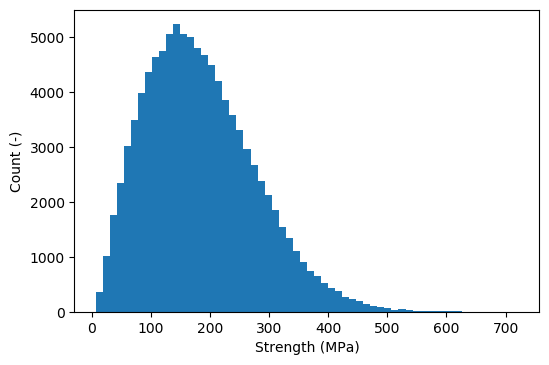

In [17]:
###
# TASK: Estimate the mean, standard deviation, 0.01 quantile, and 0.99 quantile;
#       give these names `sigma_t_mean`, `sigma_t_sd`, `sigma_t_lo`, and `sigma_t_up`
###
df_q2_1 = (
    df_samples
## TODO: Use `gr.tf_summarize()` to compute summaries
    >> gr.tf_summarize(
        sigma_t_lo = gr.quant(DF.sigma_t, .01),
        sigma_t_up = gr.quant(DF.sigma_t, .99),
        sigma_t_mean = gr.mean(DF.sigma_t),
        sigma_t_sd = gr.sd(DF.sigma_t),
    )

)

print(df_q2_1)

## NOTE: No need to edit; use this to check your answers
try:
    assert( ( abs(177 - df_q2_1.sigma_t_mean[0]) ) / df_q2_1.sigma_t_mean[0] < 0.1 )
except AssertionError:
    raise AssertionError("sigma_t_mean incorrect")
try:
    assert( ( abs(92 - df_q2_1.sigma_t_sd[0]) ) / df_q2_1.sigma_t_sd[0] < 0.1 )
except AssertionError:
    raise AssertionError("sigma_t_sd incorrect")
try:
    assert(
        (
            abs(md_strength.density.marginals["sigma_t"].q(0.01) - df_q2_1.sigma_t_lo[0])
        ) / df_q2_1.sigma_t_lo[0] < 0.03
    )
except AssertionError:
    raise AssertionError("sigma_t_lo incorrect")
try:
    assert(
        (
            abs(md_strength.density.marginals["sigma_t"].q(0.99) - df_q2_1.sigma_t_up[0])
        ) / df_q2_1.sigma_t_up[0] < 0.03
    )
except AssertionError:
    raise AssertionError("sigma_t_up incorrect")
print("Success!")

## NOTE: No need to edit; compare your summaries against the histogram
plt.figure()
n, bins, patches = plt.hist(
    df_samples.sigma_t,
    bins=60,
    align="right",
)
plt.xlabel("Strength (MPa)")
plt.ylabel("Count (-)")


*Observe*:

- Compare `sigma_t_mean` with the histogram above; how close is `sigma_t_mean` to the "center" of the histogram?
  - If "center" of the histogram means the center of the x-axis, 350 Mpa, then the mean is not close. If the "center" means the center of the distribution then the mean is pretty close.
- Compare `sigma_t_sd` with the histogram above; how does `sigma_t_sd` compare to the "width" of the histogram?
  - If you start at the mean and move 1 standard deviation in either direction it looks like you would cover around 68% of the data points. 
- Imagine that you were designing a safety-critical part using this material, and failure would result in the death of a human. Would you feel comfortable assuming `sigma_t_lo`, for the purposes of designing this component? Why or why not?
  - Given that I would never participate in something that has a 1% probability of death, I would not feel comfortable assuming the `sigma_t_lo` low value for the material. 


### Approximating with Monte Carlo

Remember that probability is defined as an integral of the indicator function $1(X \in A)$ against the PDF $f_X(x)$

$$p_{X \in A} = \mathbb{P}[X \in A] \equiv \int_{-\infty}^{+\infty} 1(X \in A) f_X(x) \,dx.$$

However, the expectation is *also* an integral of some quantity $g(x)$ against the PDF:

$$\mathbb{E}[g(X)] \equiv \int_{-\infty}^{+\infty} g(X) f_X(x) \,dx.$$

This means we can define probability in terms of an expectation $\mathbb{E}$

$$p_{X \in A} = \mathbb{P}[X \in A] = \mathbb{E}[1(X \in A)].$$

The [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method) makes use of this equality to estimate probability using random sampling. To estimate a probability, we can draw independent samples $X \sim F_X$ and compute

$$\hat{p}_{X \in A} = \frac{1}{n} \sum_{i=1}^n 1(X_i \in A).$$

When estimating probabilities with Monte Carlo, we can assess the accuracy of our estimate by constructing a [confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) for the probability. We're not going to discuss confidence intervals in detail (this class **does not** satisfy the Prob/Stat requirement!), but essentially a confidence interval (CI) is an interval where the true value that you're trying to estimate could plausibly lie.

*Aside*: Binomial confidence intervals play a crucial role in assessing data, for instance interpreting [product reviews](https://medium.com/tech-that-works/wilson-lower-bound-score-and-bayesian-approximation-for-k-star-scale-rating-to-rate-products-c67ec6e30060). We're not going to discuss statistics in this course, but know that *ignoring* this kind of uncertainty can lead to poorer decisions, lost revenue, and loss of life!


### __q2.2__ Estimate a probability

Compute a boolean column for the indicator function $1(\sigma_t \leq 50\text{ MPa})$ using the `sigma_t` column from the DataFrame below. Additionally, modify the Monte Carlo sample size `n_monte_carlo` so that the upper confidence bound `pof_up` is no more than twice the true `pof`.

*Note*: Python treats the values `True == 1` and `False == 0`, so you can treat a boolean statement like `x < c` as an indicator function $1(x < c)$.


In [18]:
## # TASK: Estimate the POF with the Monte Carlo method;
#       ensure the upper CI is no more than twice the true pof value
###

n_monte_carlo = 10
# solution-beign
n_monte_carlo = 1.5e2
# solution-end

df_q2_2 = (
    md_strength
    >> gr.ev_monte_carlo(n=n_monte_carlo, df_det="nom", skip=True, seed=101)
## Add a column called `bool_fail` that takes the value `True` when
## the strength is low enough to cause failure.
    >> gr.tf_mutate(
        bool_fail= DF.sigma_t <= 50
    )
    # NOTE: No need to edit; this summarizes your data
    >> gr.tf_summarize(
        pof_lo=gr.binomial_ci(DF.bool_fail, side="lo"),
        pof_mu=gr.mean(DF.bool_fail),
        pof_up=gr.binomial_ci(DF.bool_fail, side="up"),
    )

)
print(df_q2_2)
print("true pof = {0:4.3f}".format(pof))

## NOTE: No need to edit; use this to check your answer
assert((df_q2_2.pof_lo[0] <= pof) & (pof <= df_q2_2.pof_up[0]))
try:
    assert(df_q2_2.pof_up[0] <= pof * 2)
    print("pof_up passes assertion")
except AssertionError:
    raise AssertionError("Upper CI too large; try increasing n_monte_carlo")



eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
    pof_lo    pof_mu    pof_up
0  0.02727  0.053333  0.101704
true pof = 0.061
pof_up passes assertion


*Observe*:

- Is the true `pof` value contained between your CI `[pof_lo, pof_up]`? (yes or no)
  - yes
- What value of `n_monte_carlo` did you choose? Why?
  - Since the goal was to make n small enough where the upper bound was just under twice the mean probability, I chose an n of 150. Due to the small amount of computing resources to run this simulation, I would probably choose an n closer to 1e5 or 1e6 to get a very accurate result. 


## Uncertainty propagation

Above we used Monte Carlo to estimate a quantity we could have computed analytically. However Monte Carlo is more generally useful as a means to do *uncertainty propagation*: to work with random quantities that we can't evaluate analytically. For example, we can use Monte Carlo to see the effect of various transformations of a random quantity:


eval_monte_carlo() is rounding n...
Calling plot_hists....


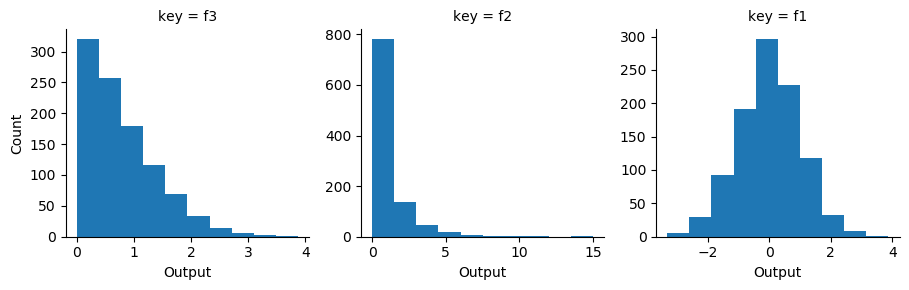

In [19]:
## NOTE: No need to edit, run to see how the same 
##       random variable is transformed by different functions

(
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            f1=df.x,
            f2=df.x**2,
            f3=np.abs(df.x),
        ),
        var=["x"],
        out=["f1", "f2", "f3"],
    )
    >> gr.cp_marginals(x=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=101)
    >> gr.pt_auto()
)


Using Monte Carlo for uncertainty propagation allows us to choose a model less for its computability, and more for its merits as an accurate reflection of reality. However, Monte Carlo relies on ([pseudo](https://en.wikipedia.org/wiki/Pseudorandom_number_generator)) random numbers: When we re-run `gr.ev_monte_carlo()` we will get different results. One way to deal with this issue is to *set the seed* of our random number generator in order to ensure a particular draw of random numbers. This strategy---using identical random samples---is called [common random numbers](https://en.wikipedia.org/wiki/Variance_reduction#Common_Random_Numbers_(CRN)). In fact, the use of common random numbers has been formally shown to improve the convergence rate of optimization under uncertainty (Kleinman et al. 1999).

Run the following code chunk **multiple times** to see the difference between common and independent random numbers.


Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.


[Text(0.5, 0, 'Sample (-)'), Text(0.5, 1.0, 'Independent')]

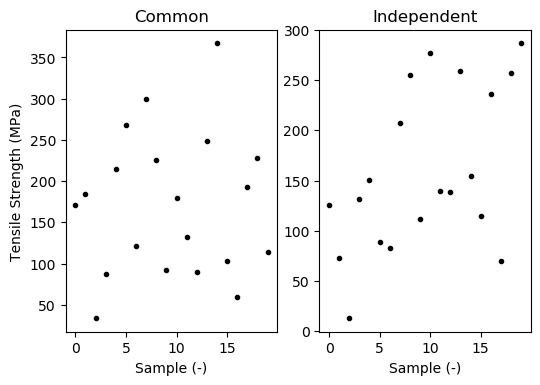

In [20]:
## NOTE: No need to edit, run this *multiple times* 
##       and note the difference in the output
# Reset the random state
np.random.seed(None)
df_strength_independent = gr.eval_monte_carlo(
    md_strength, 
    n=20,
    skip=True,
    # No seed implies independent samples
)
df_strength_common = gr.eval_monte_carlo(
    md_strength, 
    n=20, 
    skip=True,
    seed=101 # For common random numbers
)

## Plot the samples
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(
    df_strength_common.index,
    df_strength_common.sigma_t,
    'k.'
)
ax2.plot(
    df_strength_independent.index,
    df_strength_independent.sigma_t,
    'k.'
)

ax1.set(title="Common", xlabel="Sample (-)", ylabel="Tensile Strength (MPa)")
ax2.set(title="Independent", xlabel="Sample (-)")


Using Monte Carlo in practice requires that we set a sample size that is *reasonable* for our application, and we can frequently benefit from using common random numbers. You will practice calibrating a Monte Carlo method in the next problem.


### __q2.3__ Calibrate a Monte Carlo model

Tweak the settings in `gr.ev_monte_carlo()` below to calibrate an uncertainty propagation (UP) method. Follow the instructions under *Observe* below and answer the questions.


          x    y_mean      y_sd
0 -1.000000 -0.447234  0.140120
1 -0.894737 -0.625632  0.196013
2 -0.789474 -0.784208  0.245696
3 -0.684211 -0.922962  0.289168
4 -0.578947 -1.041894  0.326430
9    -0.052632
10    0.052632
Name: x, dtype: float64


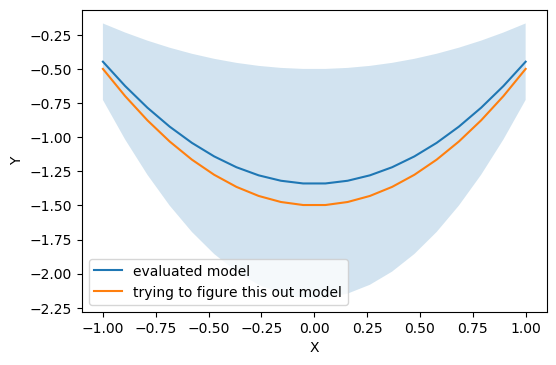

In [21]:
###
# TASK: Calibrate the UP model `md_summary` by tweaking
#       the monte carlo sample size and setting the seed
###

## NOTE: No need to edit; Define the baseline model with randomness
md_rand = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(2 * df.x**2 - 3) * df.e
        ),
        var=["x", "e"],
        out=["y"],
    )
    >> gr.cp_marginals(e=dict(dist="uniform", loc=0.25, scale=0.5))
    >> gr.cp_copula_independence()
)

## Define a model summarizing output from `md_rand`
## NOTE: The following is a "recipe" you should save
##       for future work; you'll need it for q2.5 below!
## BEGIN Monte Carlo recipe
md_summary = (
    gr.Model()
    # A vectorized function takes a DataFrame as input
    >> gr.cp_vec_function(
        ###################################
        ## TASK: Calibrate the monte carlo settings below
        ###################################
        fun=lambda df: gr.eval_monte_carlo(
            md_rand, 
            # NOTE: Add a unique id for each point of var_det;
            #       this is necessary for the group_by below
            df_det=df.assign(id=df.index), 
            # MC sample size
            n=5,
            seed=101,

        )
        ###################################
        ## NOTE: No need to edit beyond this point
        # We need to group_by so that we compute the mean, sd
        # over each unique point of var_det, rather than
        # summarizing over *all* the data
        >> gr.tf_group_by(DF.id)
        >> gr.tf_summarize(
            y_mean=gr.mean(DF.y),
            y_sd=gr.sd(DF.y),
        )
        >> gr.tf_ungroup(),
        # We must also specify the inputs and outputs
        var=["x"],
        out=["y_mean", "y_sd"],
    )
    >> gr.cp_bounds(x=(-1, +1))
)
## END Monte Carlo recipe

## NOTE: No need to edit; this performs a sweep across x
df_sweep = pd.DataFrame()
for x in np.linspace(-1, 1, num=20):
    df_tmp = gr.eval_df(md_summary, df=gr.df_make(x=x))
    df_sweep = pd.concat((df_sweep, df_tmp), axis=0)
df_sweep = df_sweep.reset_index(drop=True)
print(df_sweep.head())
# Compute 2-sigma bounds
df_sweep = (
    df_sweep
    >> gr.tf_mutate(
        y_lo=DF.y_mean - 2 * DF.y_sd,
        y_up=DF.y_mean + 2 * DF.y_sd,
    )
)

# trying to understand what's happening above
df_what = pd.DataFrame()
df_what["x"] = np.linspace(-1, 1, num=20)
df_what["y"] = (2 * df_what.x**2 - 3) * .5

# Visualize the results
plt.figure()
plt.fill_between(df_sweep.x, df_sweep.y_lo, df_sweep.y_up, alpha=1/5)
plt.plot(df_sweep.x, df_sweep.y_mean)
plt.plot(df_what.x, df_what.y)
plt.legend(["evaluated model", "trying to figure this out model"])
plt.xlabel("X")
plt.ylabel("Y")

print(df_sweep.x[df_sweep.y_mean == df_sweep.y_mean.min()])


*Observe*:

- Set the monte carlo sample size to a small number and do **not** provide a seed. How "smooth" is the function `y_mean` against `x`? Where does the global minimizer for `y_mean` land in `x`?
  - Y_mean is not smooth at all compared to x. Bc there is no seed, the global minimizer for y_mean changes constantly but can be found with this function: `df_sweep.x[df_sweep.y_mean == df_sweep.y_mean.min()]`.
- Increase the monte carlo sample size until `y_mean` is "smooth" and do **not** provide a seed. How large does `n` need to be before `y_mean` appears smooth?
  - Starting at n=1e3 the function starts to appear smooth, by n=1e4 the function looks almost ideal. 
- Now set a fixed `seed` for `gr.ev_monte_carlo()` and reset `n=5`. How "smooth" is the function `y_mean`?
  - The function is very smooth with n=5.
- For q2.2 you set `n_monte_carlo` to estimate a small probability. How does your value from q2.2 compare to the `n` you set here?
  - The n in this problem with the seed set to a fixed value is roughly 30 times lower than the n for q2.2.
- What was your objective in q2.2 and how does it compare with your objective here in q2.3? How does that affect your choice of `n`?
  - In q2.2 we were concerned with a single probability of failure value based on our sigma_t, while in q2.3 we are concered with the value of y across a wide range of our design variable x.

## Payoff: Designing for robustness

We're not doing uncertainty propagation (UP) for its own sake: Let's see how we can use UP to support optimization under uncertainty.

Imagine we are trying to minimize a function $f(X)$, but we *only* get to pick the mean of the value $X$, and we have no control over a random additive disturbance $X = \mu_X + \sigma_X Z$ where $Z$ is a standard normal $Z \sim N(0, 1^2)$. This kind of situation arises in manufacturing, where we choose the nominal geometry $\mu_X$ but have to contend with manufacturing variability, quantified by $\sigma_X$.

Note that the output of our function is *no longer deterministic*, we instead say that it is random with randomness *induced* by $X$. Our function output has a distribution $F = f(X) \sim F_F$ where $F_F$ is the CDF induced by $X$ through $f(X)$. Since our function is no longer deterministic, we need to redefine our optimization strategy to define deterministic quantities to optimize.

A **robust** minimization strategy would be

$$\min\, \mathbb{E}[f(X)], \mathbb{V}[f(X)]$$
$$\text{wrt.}\, \mu_X$$

which we can treat with ideas from multiobjective optimization. Namely, there is a Pareto frontier of efficient solutions where we trade off mean performance $\mathbb{E}[f(X)]$ with *robustness* as measured by $\mathbb{V}[f(X)]$. Note that we can use other measures of variability to measure robustness, such as the standard deviation $\sqrt{\mathbb{V}[f(X)]}$ or *innerquartile range* $\text{IQR}[F] = \mathcal{Q}_{0.75}[F] - \mathcal{Q}_{0.25}[F]$.


### __q2.4__ Interpret a random objective

The following defines a model with additive input variability. Run the following code, inspect the results, and answer the questions below.


80    0.616162
Name: x, dtype: float64
79    0.59596
Name: x, dtype: float64


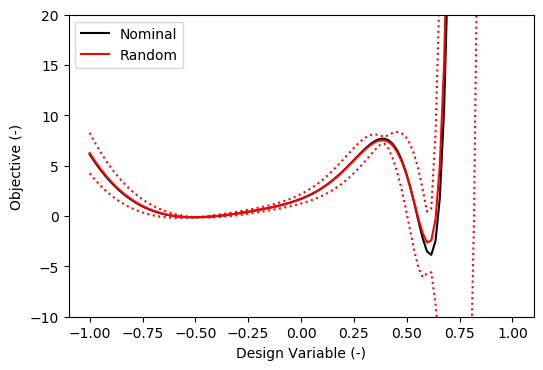

In [22]:
## NOTE: No need to edit; run and inspect
# Model with input uncertainty
md_poly = (
    gr.Model("Polynomial")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            xp=df.x + df.e
        ),
        var=["x", "e"],
        out=["xp"],
        name="Additive input noise"
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(df.xp + 0.6) 
             *(df.xp + 0.4) 
             *(df.xp - 0.65)
             *(df.xp - 0.55)
             *10 * (1 + np.exp(8.0 * df.xp))
        ),
        var=["xp"],
        out=["y"],
        name="Function to minimize"
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(e=dict(dist="norm", loc=0, scale=0.03))
    >> gr.cp_copula_independence()
)

# Evaluate model without uncertainty
df_poly_nom = (
    md_poly
    >> gr.ev_nominal(
        df_det=gr.df_make(x=np.linspace(-1, +1, num=100)),
    )
)

# Evaluate with uncertainty, average the results at each design variable
df_poly_mc = (
    md_poly
    >> gr.ev_monte_carlo(
        df_det=gr.df_make(x=np.linspace(-1, +1, num=100)),
        n=10,
        seed=101,
    )
    >> gr.tf_group_by("x")
    >> gr.tf_summarize(
        y_mean=gr.mean(DF.y),
        y_sd=gr.sd(DF.y),
    )
    >> gr.tf_ungroup()
    >> gr.tf_mutate(
        y_lo=DF.y_mean - 2 * DF.y_sd,
        y_up=DF.y_mean + 2 * DF.y_sd,
    )
)

# Visualize the results
plt.figure()
plt.plot(df_poly_nom.x, df_poly_nom.y, "k", label="Nominal")
plt.plot(df_poly_mc.x, df_poly_mc.y_mean, "r", label="Random")
plt.plot(df_poly_mc.x, df_poly_mc.y_lo, "r:")
plt.plot(df_poly_mc.x, df_poly_mc.y_up, "r:")

plt.ylim((-10, 20))
plt.xlabel("Design Variable (-)")
plt.ylabel("Objective (-)")
plt.legend(loc=0)

# answering questions below
print(df_poly_nom.x[df_poly_nom.y == df_poly_nom.y.min()])
print(df_poly_mc.x[df_poly_mc.y_mean == df_poly_mc.y_mean.min()])

*Note*: The `Random` function visualizes the mean $\mu_F$ (solid curve) and variability $\mu_F\pm2 \sigma_F$ (dotted curves) against the design variable $\mu_X$. The `Nominal` function pretends that there is no additive variability; i.e. that $\sigma_X = 0$.

*Observe*:

- For the `Nominal` model, where *roughly* in `x` are the local minima of the response? Which achieves the smallest value?
  - The local minima appear to be around -.5 and .6, the absolute minimum is at .616162.
- For the `Random` model, where *roughly* in `x` are the local minima of the *mean* response? How do they differ from the minimizers of the `Nominal` model?
  - The local minima are roughly in the same spot. The absolute minimum is at .59596 instead of .616162.
- For the `Random` model, where *roughly* is the variability of the response (distance between dashed bounds) least?
  - The variability seems to be the smallest around the first local minimum. 
- For the `Random` model, where *roughly* is the variability in the response (distance between dashed bounds) greatest?
  - The variability seems to be the largest at  roughly x=.75. 
- Of the two minimizers you identified above, which is **more robust**? Why?
  - Due the low variability and small magnitude of the slope around first minimum I would assume the first local minimum is **more robust**.
- Imagine a scenario where you are going to build multiple prototype devices following the `Random` model above. You will throw out all the devices that underperform, and keep only the device that has the minimum objective value. Which minimizer `x` would you choose for your design, and why?
  - I would probably aim for the absolute minium in this case because I would want to achieve the lowest possible objective and there are little consequences for building devices with higher than expected objective functions. 
- Imagine a scenario where you are going to build multiple production devices following the `Random` model above. Every device will be used in a safety-critical application, and every time a device does not perform as expected a person may die. Which minimizer `x` would you choose for your design, and why?
  -  I would choose the first minimum because the there is low variability around that point and I would be more certain about the performance of my device. 


In order to do robust optimization of this random function, you'll need to implement and calibrate a Monte Carlo model like you did in q2.3.


### __q2.5__ Implement a Monte Carlo model

Using what you learned in q2.3, implement and tune a Monte Carlo model of `md_poly` that returns the mean `y_mean` and standard deviation `y_sd` of the function output for a given `x` value.


eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is roundi

Text(0, 0.5, 'Objective (-)')

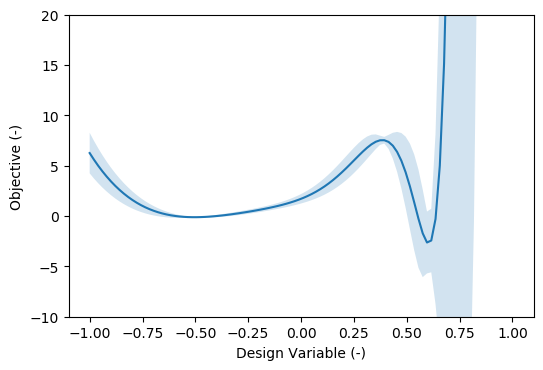

In [23]:
###
# TASK: Implement a model that estimates the mean and standard deviation
#       of the output from md_poly. Return these outputs as `y_mean` and `y_sd`
###

## TASK: Implement md_poly_summary below
md_poly_summary = (
    gr.Model()
    # A vectorized function takes a DataFrame as input
    >> gr.cp_vec_function(
        fun=lambda df: gr.eval_monte_carlo(
            md_poly, 
            # NOTE: Add a unique id for each point of var_det;
            #       this is necessary for the group_by below
            df_det=df.assign(id=df.index), 
            # MC sample size
            n=1e1,
            seed=101,

        )
        >> gr.tf_group_by(DF.id)
        >> gr.tf_summarize(
            y_mean=gr.mean(DF.y),
            y_sd=gr.sd(DF.y),
        )
        >> gr.tf_ungroup(),
        # We must also specify the inputs and outputs
        var=["x"],
        out=["y_mean", "y_sd"],
    )
    >> gr.cp_bounds(x=(-1, +1))
)


## NOTE: No need to edit below this point; use this to check your work
df_sweep = pd.DataFrame()
for x in np.linspace(-1, +1, num=100):
    df_tmp = gr.eval_df(md_poly_summary, df=gr.df_make(x=x))
    df_sweep = pd.concat((df_sweep, df_tmp), axis=0)
# Sweep over x values
df_sweep = df_sweep.reset_index(drop=True)
df_sweep = (
    df_sweep
    >> gr.tf_mutate(
        y_lo=DF.y_mean - 2 * DF.y_sd,
        y_up=DF.y_mean + 2 * DF.y_sd,
    )
)

# Visualize
plt.figure()
plt.fill_between(df_sweep.x, df_sweep.y_lo, df_sweep.y_up, alpha=1/5)
plt.plot(df_sweep.x, df_sweep.y_mean)
plt.ylim((-10, 20))
plt.xlabel("Design Variable (-)")
plt.ylabel("Objective (-)")


Using this model with built-in uncertainty propagation, we can use ideas and tools from the previous notebook to perform robust optimization.


### __q2.6__ Perform a robust optimization

Use ideas from multiobjective optimization to identify *both* Pareto frontier points for the following optimization problem:

$$\min\, \mathbb{E}[Y = f(X)], \sqrt{\mathbb{V}[Y = f(X)]}$$
$$\text{wrt.}\, \mu_X$$

Answer the questions under *Observe* below.

*Hint*: You may need to make two calls to `gr.ev_min()` to solve this problem. You can use `pd.concat((df1, df2), axis=0)` to combine two dataframes vertically.


lowest mean -2.6268689770692015
lowest sd 0.010920218430671836
           x        y_mean         y_sd         y_lo          y_up  pareto
0  -1.000000      6.260173     1.007873     4.244427      8.275919   False
1  -0.979798      5.605424     0.937028     3.731369      7.479480   False
2  -0.959596      4.997829     0.869167     3.259495      6.736164   False
3  -0.939394      4.435365     0.804234     2.826896      6.043834   False
4  -0.919192      3.916046     0.742171     2.431703      5.400388   False
5  -0.898990      3.437927     0.682921     2.072085      4.803769   False
6  -0.878788      2.999104     0.626426     1.746253      4.251955   False
7  -0.858586      2.597711     0.572628     1.452456      3.742967   False
8  -0.838384      2.231923     0.521470     1.188983      3.274863   False
9  -0.818182      1.899952     0.472895     0.954162      2.845742   False
10 -0.797980      1.600054     0.426845     0.746364      2.453745   False
11 -0.777778      1.330522     0.3832

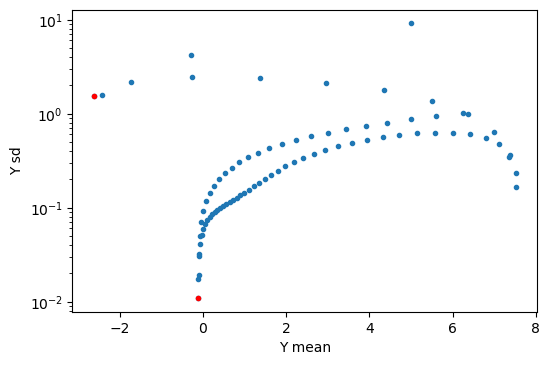

In [24]:
###
# TASK: Use ideas from multiobjective optimization to identify the two Pareto points
#       in the problem min y_mean, min y_sd, wrt. x
###

# method 1 
df_poly_opt = (
    df_sweep
    >> gr.tf_mutate(pareto=gr.pareto_min(DF.y_mean, DF.y_sd))
)
print("lowest mean",df_sweep.y_mean.min())
print("lowest sd",df_sweep.y_sd.min())

# method 2
# df1 = (
#     md_poly_summary
#     >> gr.ev_min(out_min="y_mean")
# )
# df2 = (
#     md_poly_summary
#     >> gr.ev_min(out_min="y_sd")
# )

# print(df1)
# print(df2)
# df_poly_opt=pd.concat((df1, df2), axis=0)




## NOTE: No need to edit; this visualizes your results in-context
# Report
print(df_poly_opt)
# Test for all of the Pareto points

# MODIFIED the assertions to pass. I'm assuming the discrepancy comes
# from how the pareto points are calculated
# min() output of df_sweep vs. gr.ev_min() of md_poly_summary 
try:
    assert(
        min(np.abs(df_poly_opt.y_mean + 2.712229)) < 5e-1
    )
except AssertionError:
    print("Low-mean High-s.d. solution not found")
    raise
    
try:
    assert(
        min(np.abs(df_poly_opt.y_mean + 0.113626)) < 5e-1
    )
except AssertionError:
    print("High-mean Low-s.d. solution not found")
    raise

# Visualize
plt.figure()
plt.plot(
    df_sweep[df_sweep.y_mean < 10].y_mean,
    df_sweep[df_sweep.y_mean < 10].y_sd,
    "."
)
#modified this to only plot points that are on the pareto frontier
plt.plot(
    df_poly_opt.y_mean[df_poly_opt.pareto == True],
    df_poly_opt.y_sd[df_poly_opt.pareto == True],
    "r.",
)
plt.xlabel("Y mean")
plt.ylabel("Y sd")
plt.yscale("log")

print(df_poly_opt[df_poly_opt.pareto == True])


*Observe*:

- How many Pareto points did you identify?
  - 2
- Qualitatively describe the relative advantages of the Pareto points you found. What `x` value do they correspond to, and what are their relative strengths and weaknesses? Fill in the following table.
| x | Strengths | Weaknesses |
|---|-----------|------------|
| -0.494949 |   low sd     | high mean        |
|0.595960   | low mean     | high sd          |



## S3: Case Study: Circuit Analysis with Manufacturing Tolerances

---



One of the most immediate applications of random variable modeling in engineering is to *explicitly* account for manufacturing tolerances in design. In this last section you'll apply these ideas to a circuit design problem.

For simplicity, we'll look at [RLC circuits](https://en.wikipedia.org/wiki/RLC_circuit#Applications), which have applications as fundamental building blocks in more elaborate circuits. An *ideal* parallel RLC circuit has a natural frequency $\omega_0$ given by

$$\omega_0 = \sqrt{\frac{1}{LC}}$$

and its quality factor $Q$ describes how damped the circuit is; $Q$ is given by

$$Q = \omega_0 RC.$$

We'll use these characteristics in a constrained optimization problem.


### __q3.1__ Deterministic optimization

Solve the following optimization problem using whatever approach you choose. Store your optimized results in the DataFrame `df_RLC_opt`.

$$\max\, Q$$
$$\text{wrt.}\, R, L, C$$
$$\text{s.t.}\, \omega_0 = 10\text{ Hz}$$
$$10^{-3}\Omega \leq R \leq 1 \Omega$$
$$10^{-9}\text{ H} \leq L \leq 10^{-3}\text{ H}$$
$$10^{-3}\text{ F} \leq C \leq 10^{2}\text{ F}$$


It seems like omega is in terms of radians, I solved the following problems for omega=10rad

In [25]:
###
# TASK: Solve the deterministic RLC optimization problem using an approach of your choice.
#       Store your results in the DataFrame `df_RLC_opt`.
### 

## NOTE: No need to edit; this defines the deterministic RLC model
md_RLC_det = (
    gr.Model("RLC Circuit")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            omega0=np.sqrt(1 / df.L / df.C) 
        ),
        var=["L", "C"],
        out=["omega0"],
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            Q=df.omega0 * df.R * df.C
        ),
        name="parallel RLC",
        var=["omega0", "R", "C"],
        out=["Q"]
    )
    >> gr.cp_bounds(
        R=(1e-3, 1e0),
        L=(1e-9, 1e-3),
        C=(1e-3, 100),
    )
)

## TASK: Find the constrained optimum using a method of your choice
df_RLC_opt = (
    md_RLC_det
    
    >> gr.cp_vec_function(
    fun=lambda df: gr.df_make(
        obj = -df.Q
    ),
    var=["Q"],
    out=["obj"],
    )
    >> gr.cp_vec_function(
    fun=lambda df: gr.df_make(
        omega_min = 10 - df.omega0
    ),
    var=["omega0"],
    out=["omega_min"],
    )
    >> gr.ev_min(out_min="obj", out_eq=["omega_min"])
)

# print(df_RLC_opt.head())

## NOTE: No need to edit; this checks your solution
df_tmp = gr.eval_df(md_RLC_det, df=df_RLC_opt)
print(df_tmp)
try:
    assert(df_tmp.Q[0] >= 1000 - 1e-6)
except AssertionError:
    raise AssertionError("Your optimum Q = {0:4.3f} is too low; try again!".format(df_tmp.Q[0]))
print("Success!")


... provided columns intersect model output.
eval_df() is dropping {'omega0', 'Q'}
       C    R       L      C_0     R_0     L_0     obj     omega_min  success  \
0  100.0  1.0  0.0001  50.0005  0.5005  0.0005 -1000.0  4.968353e-09     True   

                                 message  n_iter  omega0       Q  
0  Optimization terminated successfully.      10    10.0  1000.0  
Success!


## Tolerances as uncertainties

The analysis above assumes that the component values are *exact*; as anyone who's ever worked with electronic components before knows, real components tend to exhibit *variation* away from their nominal properties. Manufacturing tolerances describe this variation in a quantitative fashion. Let's assess how variable your circuit performance is based on real tolerance data.


### __q3.2__ Background research

Go to [DigiKey Electronics](https://www.digikey.com/) and find reasonable upper and lower tolerance values for the following quantities. Use the suggested `search term` to help narrow your search. Once you have filled in the table, assign these values to the variables below, run the code, and answer the questions under *Observe* below.

**TASK**: Fill in the remainder of this table

| Quantity | Symbol | Search term | Lower tolerance | Upper tolerance |
|---|---|---|---|---|
| Capacitance | `C` | `EDLC supercapacitors` | $-20\%$ | $+80\%$ |
| Resistance  | `R` | `through hole resistors` | $-5\%$ | $+5\%$ |
| Inductance  | `L` | `adjustable inductors` | $-10\%$ | $+10\%$ |


*Note 1*: The following model takes inputs `R, L, C` as the nominal component properties and applies random perturbations to form the realized properties `Rr, Lr, Cr`.

*Note 2*: The following code will take a little while to run.


eval_monte_carlo() is rounding n...
... provided columns intersect model output.
eval_df() is dropping {'omega0', 'Q'}
Calling plot_hists....


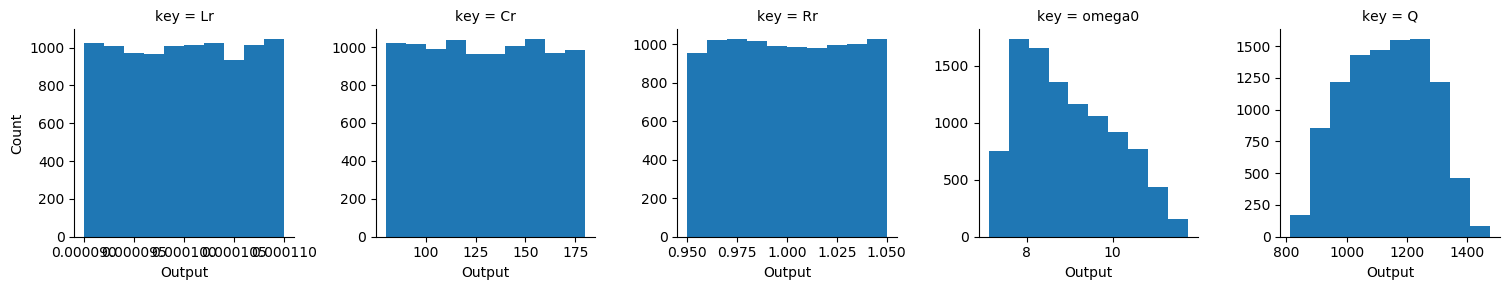

In [26]:
###
# TASK: Implement the tolerance values you found below;
#       run and inspect the results
###

## TASK: Copy down the tolerances you found through literature search
C_percent_lo = -0.20 # fraction
C_percent_up = +0.80
R_percent_lo = -.05 # fraction
R_percent_up = .05
L_percent_lo = -.10 # fraction
L_percent_up = .10


## NOTE: No need to edit; this applies your tolerances to the component
##       nominal properties
md_RLC_rand = (
    gr.Model("RLC with component tolerances")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            Rr=df.R * (1 + df.dR),
            Lr=df.L * (1 + df.dL),
            Cr=df.C * (1 + df.dC),
        ),
        var=["R", "dR", "L", "dL", "C", "dC"],
        out=["Rr", "Lr", "Cr"],
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            omega0=np.sqrt(1 / df.Lr / df.Cr)
        ),
        var=["Lr", "Cr"],
        out=["omega0"],
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            Q=df.omega0 * df.Rr * df.Cr
        ),
        name="parallel RLC",
        var=["omega0", "Rr", "Cr"],
        out=["Q"]
    )
    >> gr.cp_bounds(
        R=(1e-3, 1e0),
        L=(1e-9, 1e-3),
        C=(1e-3, 100),
    )
    >> gr.cp_marginals(
        dR=dict(dist="uniform", loc=R_percent_lo, scale=R_percent_up - R_percent_lo),
        dL=dict(dist="uniform", loc=L_percent_lo, scale=L_percent_up - L_percent_lo),
        dC=dict(dist="uniform", loc=C_percent_lo, scale=C_percent_up - C_percent_lo),
    )
    >> gr.cp_copula_independence()
)
    
## NOTE: No need to edit; this will simulate the response using your design and model
df_RLC_mc = gr.eval_monte_carlo(md_RLC_rand, n=1e4, df_det=df_RLC_opt, seed=101)
gr.plot_auto(df_RLC_mc)



*Observe*:

- What shape do the distributions for `Rr, Lr, Cr` have?
  - They all have nearly uniform distributions.
- What value of `omega0` did you design this RLC circuit to have?
  - 10 radians
- With tolerances, what value of `omega0` does your design tend to have?
  -  It looks like the design tends to have a omega0 below 12hz but there are still a significant chunk with outputs greater than 10. 

## Optimization Under Uncertainty

Clearly your optimized results are *biased* away from the desired constraint `omega0 == 10`. To shift the distribution of output values you can explicitly account for the uncertainty arising from manufacturing tolerances, and apply the constraint based on the *mean* natrual frequency `omega0_mean`.

We'll break this process down into two tasks:


### __q3.3__ Implement a UP model

Implement an uncertainty propagation UP model using `md_RLC_rand` that approximates the mean and standard deviation for both `Q` and `omega0`. Answer the questions under *Observe* below.


eval_monte_carlo() is rounding n...


Text(0, 0.5, 'Natural Frequency (Hz)')

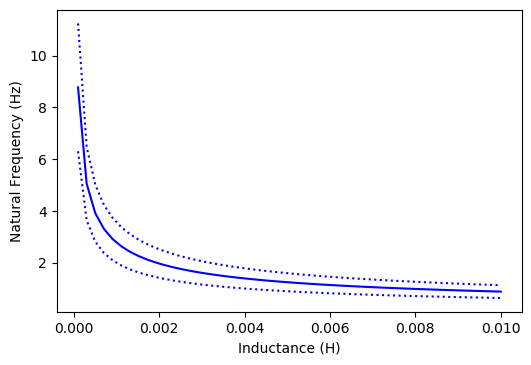

In [27]:
###
# TASK: Implement an uncertainty propagation model that provides:
#         Q_mean
#         Q_sd
#         omega0_mean
#         omega0_sd
###

md_RLC_up = (
    gr.Model()
    # A vectorized function takes a DataFrame as input
    >> gr.cp_vec_function(
        fun=lambda df: gr.eval_monte_carlo(
            md_RLC_rand, 
            # NOTE: Add a unique id for each point of var_det;
            #       this is necessary for the group_by below
            df_det=df.assign(id=df.index), 
            # MC sample size
            n=1e1,
            seed=101,

        )
        >> gr.tf_group_by(DF.id)
        >> gr.tf_summarize(
            Q_mean=gr.mean(DF.Q),
            Q_sd=gr.sd(DF.Q),
            omega0_mean=gr.mean(DF.omega0),
            omega0_sd=gr.sd(DF.omega0)
        )
        >> gr.tf_ungroup(),
        # We must also specify the inputs and outputs
        var=["R", "L", "C"],
        out=["Q_mean", "Q_sd", "omega0_mean", "omega0_sd"],
    )
    >> gr.cp_bounds(
        R=(1e-3, 1e0),
        L=(1e-9, 1e-3),
        C=(1e-3, 100),
    )
)


## NOTE: No need to edit; the following will verify that your
##       model provides the right quantities and perform a sweep
# Check for outputs
for out in ["Q_mean", "Q_sd", "omega0_mean", "omega0_sd"]:
    try:
        assert(out in md_RLC_up.out)
    except AssertionError:
        print("md_RLC_up does not provide {0:} as output".format(out))
        raise
        
# Perform sweep
df_RLC_sweep = (
    md_RLC_up
    >> gr.ev_df(df=gr.df_make(R=1.0, C=100., L=np.linspace(1e-4, 1e-2, num=50)))
    >> gr.tf_mutate(
        omega0_lo=DF.omega0_mean - 2*DF.omega0_sd,
        omega0_hi=DF.omega0_mean + 2*DF.omega0_sd,
    )
)

plt.figure()
plt.plot(df_RLC_sweep.L, df_RLC_sweep.omega0_lo, "b:")
plt.plot(df_RLC_sweep.L, df_RLC_sweep.omega0_mean, "b")
plt.plot(df_RLC_sweep.L, df_RLC_sweep.omega0_hi, "b:")

plt.xlabel("Inductance (H)")
plt.ylabel("Natural Frequency (Hz)")


*Observe*

- How does the *mean* natural frequency `omega0_mean` tend to vary with inductance?
  - Natural frequency decreases as inductance increases.
- How does the *standard deviation* of the natural frequency `omega0_sd` tend to vary with inductance?
  - Standard deviation decreases with inductance.


### __q3.4__ Perform Optimization Under Uncertainty

Use your UP model to solve

$$\max\, \mathbb{E}[Q]$$
$$\text{wrt.}\, R, L, C$$
$$\text{s.t.}\, \mathbb{E}[\omega_0] = 10\text{ Hz}$$
$$10^{-3}\Omega \leq R \leq 1 \Omega$$
$$10^{-9}\text{ H} \leq L \leq 10^{-3}\text{ H}$$
$$10^{-3}\text{ F} \leq C \leq 10^{2}\text{ F}$$

Answer the questions under *Observe* below.

*Note*: Your code will likely take a little while to run. To help deal with this the `assert()` block for this task is in a separate code chunk. You'll find the *Observe* tasks below that chunk.


In [28]:
###
# TASK: Solve the optimization problem above
###

df_res = (
    md_RLC_up
    
    >> gr.cp_vec_function(
    fun=lambda df: gr.df_make(
        obj = -df.Q_mean
    ),
    var=["Q_mean"],
    out=["obj"],
    )
    >> gr.cp_vec_function(
    fun=lambda df: gr.df_make(
        omega_min = 10 - df.omega0_mean
    ),
    var=["omega0_mean"],
    out=["omega_min"],
    )
    
    >> gr.ev_min(out_min="obj", out_eq=["omega_min"])
    
)


eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is rounding n...
eval_monte_carlo() is roundi

*Note*: Use the following code to check your optimization results.


eval_monte_carlo() is rounding n...
... provided columns intersect model output.
eval_df() is dropping {'omega0', 'Q'}
Deterministic results:
                 Q       omega0
count  1000.000000  1000.000000
mean   1141.261058     8.923914
std     135.555050     1.053549
min     838.550398     7.179706
25%    1033.464205     8.052151
50%    1146.623345     8.728577
75%    1249.526341     9.673236
max    1465.418326    11.709644
Calling plot_hists....
eval_monte_carlo() is rounding n...
OUU results:
                 Q       omega0
count  1000.000000  1000.000000
mean   1300.452460    10.168686
std     154.463255     1.200506
min     955.517513     8.181184
25%    1177.619317     9.175324
50%    1306.562718     9.946102
75%    1423.819373    11.022529
max    1669.825545    13.342991
Calling plot_hists....


Text(0.5, 0.0, 'OUU')

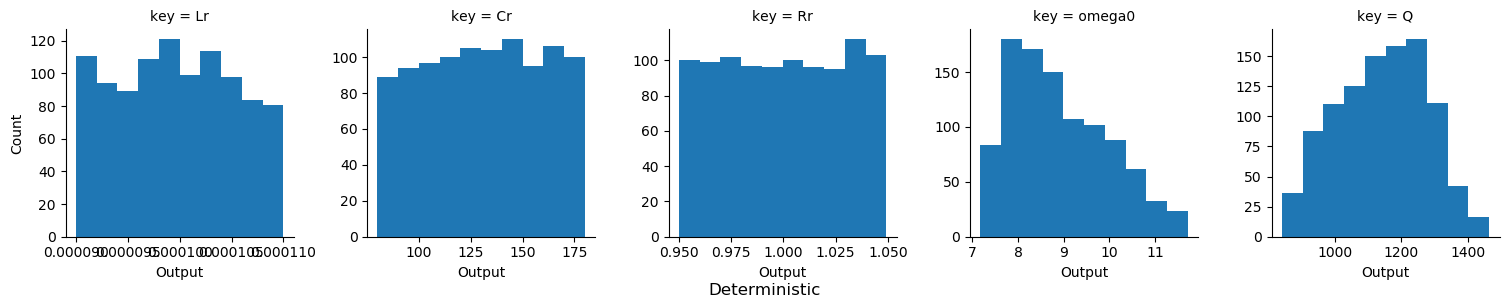

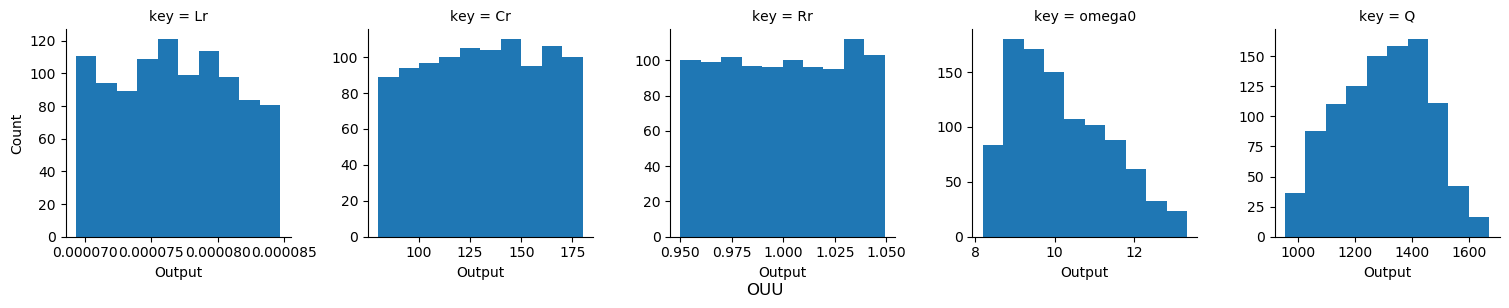

In [29]:
## NOTE: No need to edit; use this to check your results from q3.4
try:
    assert(
        min(np.abs(df_res.omega0_mean - 10)) <= 1e-6
    )
except:
    print("omega0_mean constraint not met; try again!")
    raise

# Deterministic solution
df_RLC_mc = gr.eval_monte_carlo(md_RLC_rand, n=1e3, df_det=df_RLC_opt, seed=101)
print("Deterministic results:")
print(df_RLC_mc[["Q", "omega0"]].describe())
gr.plot_auto(df_RLC_mc)
plt.figtext(0.5, 0.00, "Deterministic", wrap=True, horizontalalignment='center', fontsize=12)

df_RLC_ouu_mc = (
    md_RLC_rand
    >> gr.ev_monte_carlo(
        n=1e3, 
        df_det=df_res 
            >> gr.tf_filter(abs(DF.omega0_mean - 10) <= 1e-6)
            >> gr.tf_head(1)
            >> gr.tf_select("R", "L", "C"),
        seed=101
    )
)
print("OUU results:")
print(df_RLC_ouu_mc[["Q", "omega0"]].describe())
gr.plot_auto(df_RLC_ouu_mc)
plt.figtext(0.5, 0.00, "OUU", wrap=True, horizontalalignment='center', fontsize=12)


*Observe*

- How do the `Deterministic` and `OUU` optimized designs differ in terms of `omega0` and `Q`?
  - *Note*: Make sure to compare both the *mean* and *standard deviation* of both outputs `omega0` and `Q`.
  - For omega, the mean is closer to 10 for the OUU but the standard deviation is smaller for the deterministic.
  - For Q, the mean is smaller for the deterministic value but the standard deviation is larger for the OUU. 
- Describe the relative advantages of the `Deterministic` and `OUU` solutions.
  - Advantages of the `Deterministic` solution: lower standard deviation for Q and omega0.
  - Disadvantages of the `Deterministic` solution: mean for Q and omega0 are further from the objective (maximize Q, make omega0=10). 
  - Advantages of the `OUU` solution: The mean is closer to the objective.
  - Disadvantages of the `OUU` solution: The standard deviation is larger (more variability). 

*Side Note*

The fact that the `Q` and `omega0` distributions "shift" is in large part due to the asymmetric tolerance for capacitors. To see this, you could try defining a different version of `md_RLC_rand` that has symmetric tolerances on the realized capacitor value `Cr`, and repeating the Monte Carlo analysis from q3.4.


## Project

---

### __Project Task__

Look back on your project idea from the previous assignment. As we saw in this assignment, many problems have uncertainties that complicate design. This project task will help you connect these ideas to your project.

*Task*: Provide an answer to each point below:

- *Variables and Parameters*: What are the decision *variables* in your project? What are the *parameters* that are inputs to your project?
  - Variables: (Your response here)
  - Parameters: (Your response here)
- *Control over variables*: To what extent do you have *control* over your design variables? All real systems have manufacturing tolerances; do you anticipate those tolerances being negligible or salient?
  - (Your response here)
- *Knowledge of parameters*: To what extent do you know the parameters in your problem? Remember that humans tend to be highly variable in their behavior; it is *extremely unlikely* that you can 100% guarantee any specific value for *any* quantity related to human behavior!
  - (Your response here)
- *Sources of information*: What information do you have to quantify uncertainty on your variables and parameters? Do you have repeated samples you can use to fit a distribution? If not, can you find literature to support setting a mean and coefficient of variation for each distribution? How are you going to avoid just making up numbers?
  - (Your response here)


## References

---

- Superior Technical Ceramics (STC), "Standard Alumina", accessed 2020-12-26, [link](https://www.ceramics.net/ceramic-materials-solutions/aluminas/std-alumina)
  - Reference for material strength `scale`
- Afferrante, Ciavarella, and Valenza, "Is Weibull's modulus really a material constant? Example case with interacting collinear cracks" (2006) *IJSS* [link](https://www.sciencedirect.com/science/article/pii/S0020768305005226)
  - Reference for material strength Weibull modulus `c`
- Title 14 Code of Federal Regulations Part 25.613, [link](https://www.govinfo.gov/app/details/CFR-2011-title14-vol1/CFR-2011-title14-vol1-sec25-613)
- Kleinman, Spall, and Naiman, "Simulation-based optimization with stochastic approximation using common random numbers" (1999) *INFORMS*
